In [6]:
import sys
import numpy as np
from itertools import takewhile
import logging
from logbuilder import buildLogger
from scipy import optimize

"""
def searchOpt(C):

    @C: historical prices with corr high than rho

    numAssets = C.shape[0]
    logger = logging.getLogger('CORN') 
    
    b = cp.Variable(numAssets, pos = True)
    prob = cp.Problem(cp.Minimize(-1 * cp.sum(cp.log(C.T * b))), [cp.sum(b) == 1])
    logger.debug('Solving Problem: ' + str(prob.solve(solver = 'SCS', warm_start = True)))
    return np.array(b.value)
    
"""

def searchOpt(C):
    numAssets = C.shape[0]
    b = np.zeros(numAssets)
    objective = lambda y: -np.sum(np.log(np.maximum((C - 1).T * y + 1, 1e-6)))
    cons = ({'type': 'eq', 'fun': lambda b: 1 - sum(b)},)
    res = optimize.minimize(objective, b, bounds= [[(0,1)] * numAssets][0] , constraints=cons, method='slsqp', options={"ftol": 1e-16})
    return np.array(res.x)


class expert():
    def __init__(self, rho, timeWindow, initialWealth = 1):
        """
        initialize:
        @rho: correlation threshold
        @timeWindow: specific time windows
        @initialWealth: wealth
        """
        self.rho =rho
        self.timeWindow = timeWindow
        self.wealth = initialWealth

    def __eq__(self, other):
        """
        Used for wealth ranking
        """
        return self.wealth == other.wealth

    def __lt__(self, other):
        """
        Used for wealth ranking
        """
        return self.wealth < other.wealth

    def learning(self, Xh):
        """
        @Xh: historical prices until time t, m*(t-1)
        Return:
        @portfolio: array of weights put on each assets
        """
        # Use h instead of t here since h = t-1
        numAssets, h = Xh.shape
        self.portfolio = np.ones(numAssets)/numAssets
        # if have reached w(timeWindow) + 1 days
        if h > self.timeWindow:
            indexSet = [np.corrcoef(Xh[:,-self.timeWindow:].reshape(-1), Xh[:,i-self.timeWindow: i].reshape(-1))[1][0] >= self.rho\
                        for i in range(self.timeWindow ,h)]
            if sum(indexSet) > 0:
                self.portfolio = searchOpt(Xh[:,self.timeWindow:][:,indexSet])
        return self.portfolio
    def update(self, xt):
        """
        Update at the end of the day
        @xt: prices of the current trading day
        """
        self.wealth *= np.sum(self.portfolio * xt)



def combine(portfolioSet, wealthSet, q):
    """
    Combine the experts' portfolios
    @portfolioSet: array of portfolios, W * m(numAssets)
    @wealthSet: array of experts' current wealth, W
    @q: array of probability distribution function, W
    """
    nome = np.sum(portfolioSet.T * wealthSet * q, axis = 1)
    deno = np.sum(wealthSet * q)
    return nome/deno


def checkParams(**kwargs):
    if "rho" in kwargs:
        return False
    elif not "P" in kwargs and "K" in kwargs:
        raise ValueError("Definition for both P and K are required for CORNK")
    return True


def CORN(X, W, **kwargs):
    """
    main algorithm
    @W: maximum time window length
    @X: historical prices matrix, m(numAssets) * T
    There are two set of possible optional parameters:
    CORNU:
    @rho: correlation threshold
    CORNK:
    @P: max number of correlation thresholds
    @K: the value of K for top-K
    """
    logger = logging.getLogger('CORN')
    IS_CORNK = checkParams(**kwargs)
    # Initialize weights q and wealth
    wealth = 1
    wealthRecord = [1]
    numAssets, T = X.shape
    if IS_CORNK:
        K = kwargs["K"]
        P = kwargs["P"]
        q = np.ones(W*P)/(W*P)
        rhoSet = np.arange(P)/P
        expertPort = [expert(rho,w) for w in range(1,W+1) for rho in rhoSet]
    else:
        rho = kwargs["rho"]
        q = np.ones(W)/W
        expertPort = [expert(rho,w) for w in range(1,W+1)]

    for t in range(T):
        if t%100 == 1:
            print(t)
        logger.info('Start Day ' + str(t))
        portfolioSet = [expertI.learning(X[:,:t]) for expertI in expertPort]
        wealthSet = [expertI.wealth for expertI in expertPort]
        portfolioOverall = combine(np.array(portfolioSet), np.array(wealthSet), q)
        wealth *= np.sum(portfolioOverall * X[:,t])
        for expertI in expertPort:
            expertI.update(X[:,t])
        logger.info('End Day with wealth '+ str(wealth))
        wealthRecord.append(wealth)
        if IS_CORNK:
            topK = np.argsort(expertPort)[:K]
            logger.debug("The top K experts are: " +  str(topK))
            q.fill(0)
            q[topK] = 1/K
    return wealthRecord

In [2]:
import pickle as pkl
X = pkl.load(open("nyse_o_np.pkl", "rb"))
T = 1000
X = X[:,:T]

In [3]:
X.shape

(36, 1000)

In [7]:
import time
start = time.time()
wr = CORN(X, 7, rho = 0.4)
end = time.time()

1
101
201
301
401
501
601
701
801
901


In [8]:
end - start

635.9695498943329

In [9]:
from couru_multi2 import CORNU
import time
start = time.time()
wr, pr = CORNU(0.4, 7, X)
end = time.time()

In [10]:
end - start

55.82414436340332

In [16]:
from itertools import accumulate
from operator import mul
X_cum = [list(accumulate(i, mul)) for i in X]

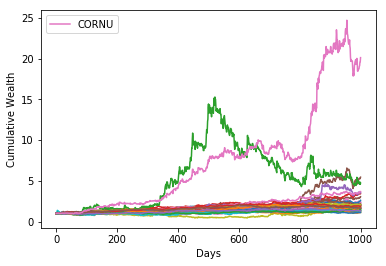

In [24]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1000), np.array(X_cum).T)
plt.plot(np.arange(1000),wr[:1000], label = "CORNU")
plt.xlabel("Days")
plt.ylabel("Cumulative Wealth")
plt.legend()